In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pingouin as pg

%matplotlib inline

# Import the data

In [159]:
path_cohort_1 = '/home/ds/Ntrk2_KOs/2018_12/HP/2018-12-19_Hotplate_Ntrk2_Rohr.xlsx'
df_1 = pd.read_excel(path_cohort_1)

In [160]:
path_cohort_2 = '/home/ds/Ntrk2_KOs/2019_07/HP/Hotplate_cohort_2.xlsx'
df_2 = pd.read_excel(path_cohort_2)

# Preprocessing:

In [161]:
# Preprocessing of cohort 1:
# Adapt column names
df_1.columns = ['Tier Nr.', 'Latenz', 'Grund']

# Add information about group and cohort ids:
l_group_ids = ['tg', 'tg', 'tg', 'wt', 'tg', 'tg', 'tg', 'wt', 'wt', 'wt', 'wt']
l_group_ids.reverse()
df_1['Gruppe'] = l_group_ids
df_1['Kohorte'] = 0

# Change column order
df_1 = df_1[['Tier Nr.', 'Gruppe', 'Kohorte', 'Latenz', 'Grund']]

In [162]:
# Preprocessing data of cohort 2:
# Select columns with data about wts and kos:
df_21 = df_2[list(df_2.columns)[:3]].copy()
df_22 = df_2[list(df_2.columns)[-3:]].copy()

# Adapt column names and concat to single df
df_21.columns = ['Tier Nr.', 'Latenz', 'Gruppe']
df_22.columns = ['Tier Nr.', 'Latenz', 'Gruppe']

# Rename kos as tg:
df_22['Gruppe'] = 'tg'

df_2 = pd.concat([df_21, df_22])

# Add information about cohort
df_2['Kohorte'] = 1

# Change column order
df_2 = df_2[['Tier Nr.', 'Gruppe', 'Kohorte', 'Latenz']]

In [163]:
df = pd.concat([df_1, df_2])
df.to_csv('HP_cohorts_1_and_2.csv')

# __Calculate statstics__

In [224]:
d_stats = {}

# Retrieve data
data_wt = list(df.loc[df['Gruppe'] == 'wt', 'Latenz'].values)
data_tg = list(df.loc[df['Gruppe'] == 'tg', 'Latenz'].values)

# Test for normal distribution (Shapiro):
d_stats['normality_wt'] = (pg.normality(data_wt).loc[0, 'normal'], pg.normality(data_wt).loc[0, 'pval'].round(3))
d_stats['normality_tg'] = (pg.normality(data_tg).loc[0, 'normal'], pg.normality(data_tg).loc[0, 'pval'].round(3))

# Test for homoscesdasticity (Levenes):
d_stats['equal_var'] = (pg.homoscedasticity([data_wt, data_tg]).loc['levene', 'equal_var'], pg.homoscedasticity([data_wt, data_tg]).loc['levene', 'pval'].round(3))

# Perform either parametric or non-parametric pairwise test:
if (d_stats['normality_wt'][0] == True) & (d_stats['normality_tg'][0] == True) & (d_stats['equal_var'][0] == True):
    d_stats['pairwise_test'] = ('ttest', pg.ttest(x=data_wt, y=data_tg).loc['T-test', 'p-val'].round(4) <= 0.05, pg.ttest(x=data_wt, y=data_tg).loc['T-test', 'p-val'].round(4))
else:
    d_stats['pairwise_test'] = ('MWU', pg.mwu(x=data_wt, y=data_tg).loc['MWU', 'p-val'].round(4) <= 0.05, pg.mwu(x=data_wt, y=data_tg).loc['MWU', 'p-val'].round(4))
    
d_stats

{'normality_wt': (True, 0.083),
 'normality_tg': (True, 0.447),
 'equal_var': (True, 0.914),
 'pairwise_test': ('ttest', False, 0.2963)}

# __Plot results__

## Setup figure design and annotate_stats function:

In [246]:
SMALL_SIZE = 16
MEDIUM_SIZE = 17
BIGGER_SIZE = 19
LINE_WIDTH = 2
SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels 
plt.rc('axes', linewidth=LINE_WIDTH)     # linewidth of x and y axis
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('xtick.major', size=10)    # linewidth of x ticks
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick.major', size=10)    # linewidth of y ticks
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def annotate_stats_gt(data_grp1, data_grp2, axis, subplot):
    max_total = max([max(data_grp1), max(data_grp2)])
    x1, x2 = 0, 1
    y, h, col = max_total + max_total * 0.05, max_total * 0.05, 'k'
    stars = '$\it{n.s.}$'
    if d_stats['pairwise_test'][2] < 0.001:
        subplot = axis.plot([x1, x2], [y+h, y+h], lw=1.5, c=col)
        stars = '***'
    elif d_stats['pairwise_test'][2] < 0.01:
        subplot = axis.plot([x1, x2], [y+h, y+h], lw=1.5, c=col)
        stars = '**'
    elif d_stats['pairwise_test'][2] < 0.05:
        subplot = axis.plot([x1, x2], [y+h, y+h], lw=1.5, c=col)
        stars = '*'

    subplot = axis.text((x1+x2)*.5, max_total, stars, ha='center', va='bottom', color=col)

    labels = ['WT', '$\it{Ntrk2}$$^{+/-}$']

    axis.axes.set_xticklabels(labels)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.axes.set_ylabel('latency [s]')

## Latency to react:

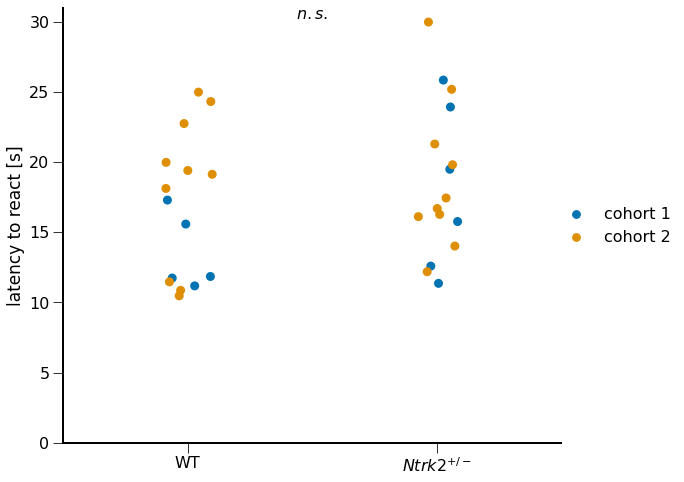

In [249]:
fig = plt.figure(figsize=(10, 7), facecolor='w')

ax1 = fig.add_subplot()
plt_hp = sns.stripplot(data=df, x='Gruppe', y='Latenz', hue='Kohorte', size=SIZE, palette='colorblind', ax=ax1)
annotate_stats_gt(data_wt, data_tg, ax1, plt_hp)
current_handles, current_labels = plt.gca().get_legend_handles_labels()
current_labels = ['cohort 1', 'cohort 2']
plt.legend(current_handles, current_labels, ncol=1, loc='center right', frameon=False, bbox_to_anchor=(1.25, 0.5))
plt.ylabel('latency to react [s]')
plt.xlabel('')

plt.ylim(0)




plt.tight_layout()
plt.savefig('HotPlate.png', dpi=300)

plt.show()